In [1]:
import numpy as np
import pandas as pd
import math
import os
import sys
import glob
import time
import pickle
import h5py
import itertools
import altair as alt
alt.data_transformers.disable_max_rows()

from astropy import units as u
from astropy.timeseries import LombScargle

from scipy.spatial.distance import euclidean

from sklearn.preprocessing import MinMaxScaler

from dtaidistance import dtw, clustering
from dtaidistance import dtw_visualisation as dtwvis

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import rc
plt.style.use('classic')
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rc('figure', facecolor='w')
rc('xtick', labelsize=20)
rc('ytick', labelsize=20)

import multiprocessing as mp
from multiprocessing import Pool
print("Number of processors: ", mp.cpu_count())

sys.path.append('/astro/users/jbirky/projects/tess_binaries')
os.environ['TESS_DATA'] = '/data/epyc/projects2/tess'

import tess_binaries as tb

Number of processors:  96


In [2]:
ff = h5py.File(f'{tb.cat_dir}/asassn_tess_inspected.hdf5', mode="r")

df = {}
for key in list(ff):
    if key == 'type':
        df[key] = np.array(ff[key].value, dtype='str')
    else:
        df[key] = ff[key].value
    
ff.close()
sample = pd.DataFrame(data=df)

/epyc/opt/anaconda/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [3]:
ls_period, bls_period = [], []
full_df = []
for ID in list(sample['tic_id']):
    infile = open(f'{tb.ps_dir}/{ID}_ps.pkl','rb')
    ps_dict = pickle.load(infile)
    infile.close()
    ls_period.append(ps_dict['ls_best_period'])
    bls_period.append(ps_dict['bls_best_period'])
    full_df.append(ps_dict['data'])
sample['ls_period']  = np.array(ls_period)
sample['bls_period'] = np.array(bls_period)
# sample['dataframes'] = full_df

In [5]:
np.where(sample['type'] == 'EA')[0]

array([   2,    4,    6,   13,   17,   18,   21,   24,   26,   28,   33,
         34,   40,   41,   42,   60,   68,   74,   81,   84,   85,   87,
         94,  105,  117,  120,  126,  127,  128,  130,  133,  148,  150,
        157,  158,  160,  164,  187,  190,  191,  204,  209,  224,  226,
        229,  234,  240,  241,  242,  254,  270,  274,  281,  285,  289,
        292,  296,  308,  315,  316,  319,  321,  322,  325,  326,  331,
        332,  340,  344,  349,  352,  353,  354,  356,  365,  367,  369,
        372,  373,  374,  375,  387,  400,  432,  434,  454,  456,  458,
        468,  476,  479,  482,  490,  491,  496,  501,  512,  528,  531,
        534,  545,  551,  557,  565,  585,  590,  624,  629,  631,  702,
        729,  769,  777,  791,  792,  801,  814,  815,  816,  824,  825,
        829,  830,  831,  832,  833,  835,  837,  839,  842,  843,  844,
        848,  851,  853,  854,  856,  858,  859,  861,  865,  868,  869,
        871,  872,  874,  877,  879,  882,  887,  8

/astro/users/jbirky/.local/lib/python3.6/site-packages/dtaidistance/dtw.py:302: RuntimeWarning: invalid value encountered in sqrt
  dtw = np.sqrt(dtw)
/epyc/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/epyc/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/epyc/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


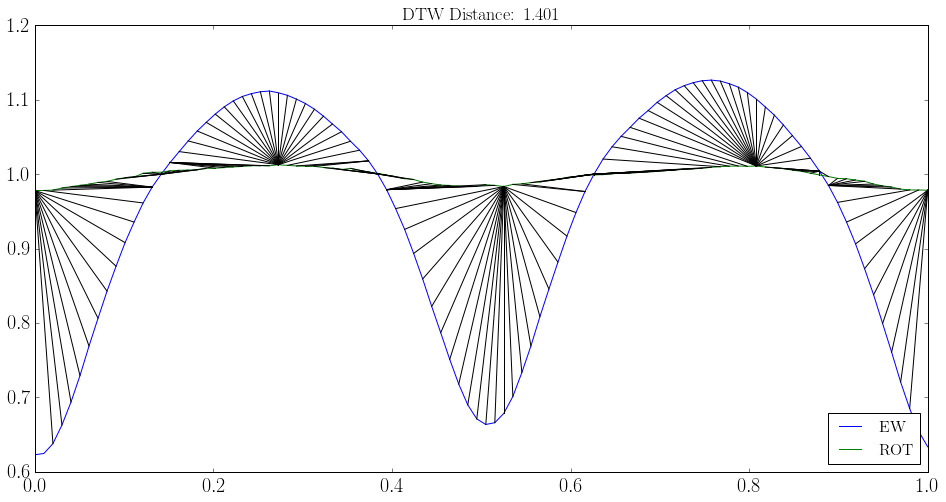

In [4]:
i, j = 5, 410
scale = False

flux1 = tb.preprocessData(full_df[i], 2*sample['ls_period'][i], scale=scale)
flux2 = tb.preprocessData(full_df[j], 2*sample['ls_period'][j], scale=scale)

tb.plotDTW(flux1, flux2, types=[sample['type'][i], sample['type'][j]])

/astro/users/jbirky/.local/lib/python3.6/site-packages/dtaidistance/dtw.py:302: RuntimeWarning: invalid value encountered in sqrt
  dtw = np.sqrt(dtw)


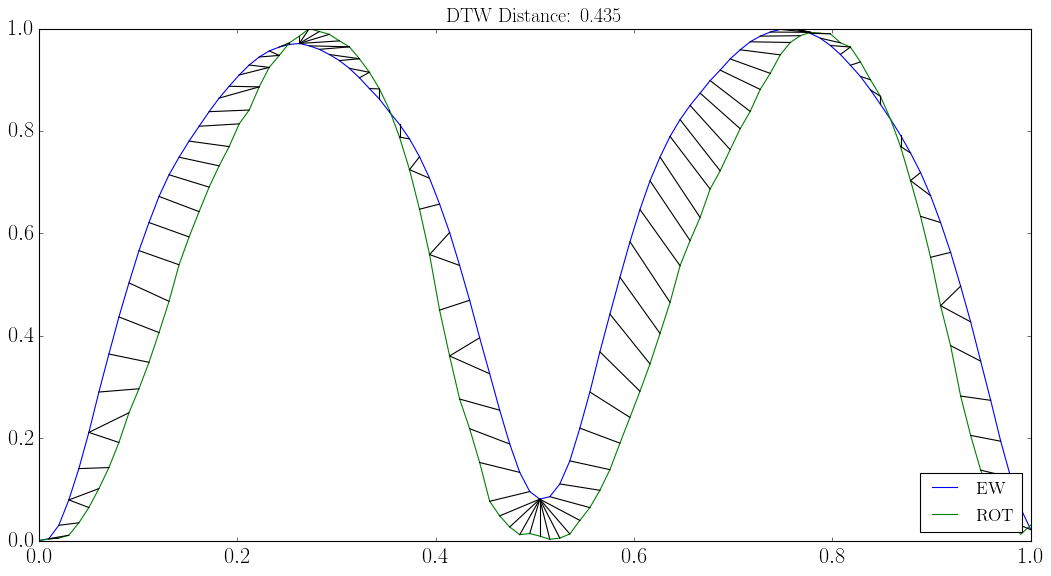

/astro/users/jbirky/.local/lib/python3.6/site-packages/dtaidistance/dtw.py:302: RuntimeWarning: invalid value encountered in sqrt
  dtw = np.sqrt(dtw)


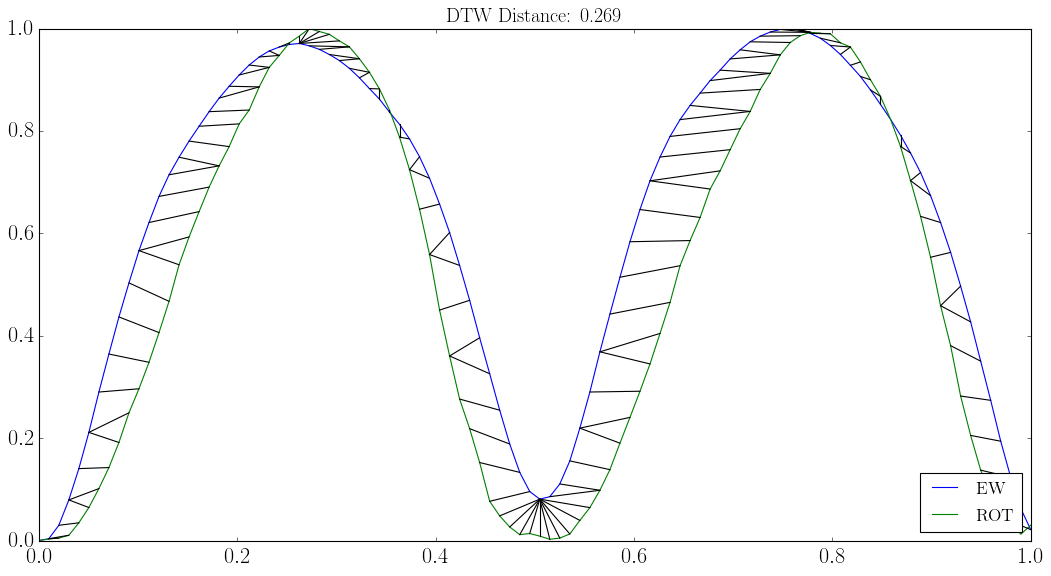

/astro/users/jbirky/.local/lib/python3.6/site-packages/dtaidistance/dtw.py:302: RuntimeWarning: invalid value encountered in sqrt
  dtw = np.sqrt(dtw)


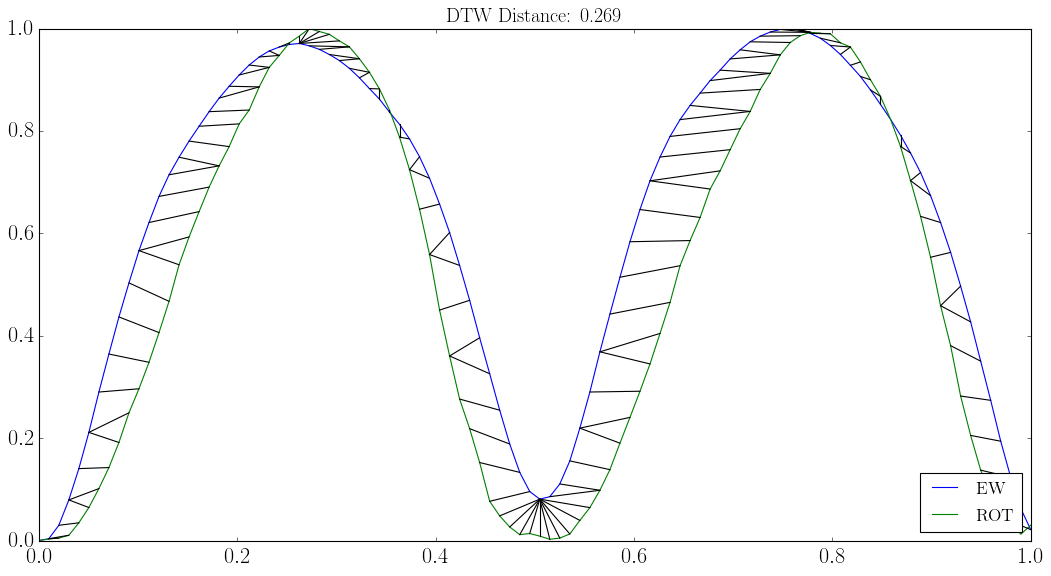

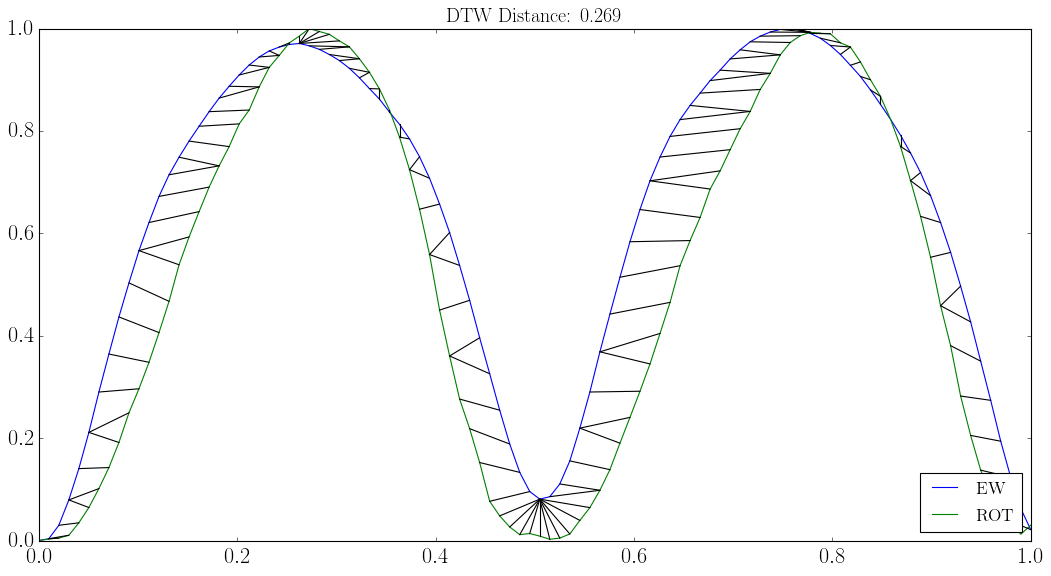

In [92]:
i, j = 5, 23

flux1 = preprocessData(full_df[i], 2*sample['ls_period'][i])
flux2 = preprocessData(full_df[j], 2*sample['ls_period'][j])

for w in [5,10,50,100]:
    plotDTW(flux1, flux2, window=w, types=[sample['type'][i], sample['type'][j]])